# Introduction

The data comes from the past Kaggle challenge "Challenges in Representation Learning: Facial Expression Recognition Challenge":

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. Each image corresponds to a facial expression in one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains approximately 36K images.

The original data consisted in arrays with a greyscale value for each pixel. We converted this data into raw images and splitted them in multiple folders: 

images/<br>
&nbsp;&nbsp;&nbsp;&nbsp;train/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;angry/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;disgust/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fear/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;happy/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;neutral/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;sad/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;surprise/<br>
&nbsp;&nbsp;&nbsp;&nbsp;validation/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;angry/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;disgust/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fear/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;happy/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;neutral/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;sad/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;surprise/<br>

80% of our images are contained inside the train folder, and the last 20% are inside the validation folder.

# Quick data visualization

First let's see how our images look like:

In [1]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "../input/face-expression-recognition-dataset/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

ImportError: cannot import name 'load_img' from 'keras.preprocessing.image' (C:\Users\iulia\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py)

Can you guess which images are related to which expressions? 

This task is quite easy for a human, but it may be a bit challenging for a predictive algorithm because:
- the images have a low resolution
- the faces are not in the same position
- some images have text written on them
- some people hide part of their faces with their hands

However all this diversity of images will contribute to make a more generalizable model.

In [2]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3205 surprise images
4103 fear images
3993 angry images
4982 neutral images
4938 sad images
436 disgust images
7164 happy images


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

# Setup the data generators

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator. 

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


# Setup our Convolutional Neural Network (CNN)

We chose to use a Convolutional Neural Network in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.

**Quick reminder of what a NN is:**

A Neural Network is a learning framework that consists in multiple layers of artificial neurons (nodes). Each node gets weighted input data, passes it into an activation function and outputs the result of the function:

![](https://skymind.ai/images/wiki/perceptron_node.png)

A NN is composed of several layers of nodes:

![](https://www.researchgate.net/profile/Martin_Musiol/publication/308414212/figure/fig1/AS:409040078295040@1474534162122/A-general-model-of-a-deep-neural-network-It-consists-of-an-input-layer-some-here-two.png)

- An input layer that will get the data. The size of the input layer depends on the size of the input data.
- Some hidden layers that will allow the NN to learn complex interactions within the data. A Neural Network with a lot of hidden layers is called a Deep Neural Network.
- An output layer that will give the final result, for instance a class prediction. The size of this layer depends on the type of output we want to produce (e.g. how many classes do we want to predict?)

Classic NNs are usually composed of several fully connected layers. This means that every neuron of one layer is connected to every neurons of the next layer. 

Convolutional Neural Networks also have Convolutional layers that apply sliding functions to group of pixels that are next to each other. Therefore those structures have a better understanding of patterns that we can observe in images. We will explain this in more details after.

Now let's define the architecture of our CNN:

In [4]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

We define our CNN with the following global architecture:
- 4 convolutional layers
- 2 fully connected layers

The convolutional layers will extract relevant features from the images and the fully connected layers will focus on using these features to classify well our images. This architecture was inspired by the following work on the subject: https://github.com/jrishabh96/Facial-Expression-Recognition

Let's focus on how our convolution layers work. Each of them contain the following operations:
- A convolution operator: extracts features from the input image using sliding matrices to preserve the spatial relations between the pixels. The following image summarizes how it works:
![](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)

The green matrix corresponds to the raw image values. The orange sliding matrix is called a 'filter' or 'kernel'. This filter slides over the image by one pixel at each step (stride). During each step, we multiply the filter with the corresponding elements of the base matrix. There are different types of filters and each one will be able to retrieve different image features:
![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-05-at-11-03-00-pm.png?w=342&h=562)

- We apply the ReLU function to introduce non linearity in our CNN. Other functions like tanh or sigmoid could also be used, but ReLU has been found to perform better in most situations.
- Pooling is used to reduce the dimensionality of each features while retaining the most important information. Like for the convolutional step, we apply a sliding function on our data. Different functions can be applied: max, sum, mean... The max function usually performs better.
![](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

We also use some common techniques for each layer:
- Batch normalization: improves the performance and stability of NNs by providing inputs with zero mean and unit variance.
- Dropout: reduces overfitting by randomly not updating the weights of some nodes. This helps prevent the NN from relying on one node in the layer too much.

We chose softmax as our last activation function as it is commonly used for multi-label classification.

Now that our CNN is defined, we can compile it with a few more parameters. We chose the Adam optimizer as it is one of the most computationally effective. We chose the categorical cross-entropy as our loss function as it is quite relevant for classification tasks. Our metric will be the accuracy, which is also quite informative for classification tasks on balanced datasets.

# Train the model

Everything is set up, let's train our model now!

In [ ]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [ ]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

In [ ]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model. 

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

Finally we can plot the confusion matrix in order to see how our model classified the images:

In [5]:
from keras.models import model_from_json

json_file = open('../input/pre-trained-model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../input/pre-trained-model/model_weights.h5")

<Figure size 432x288 with 0 Axes>

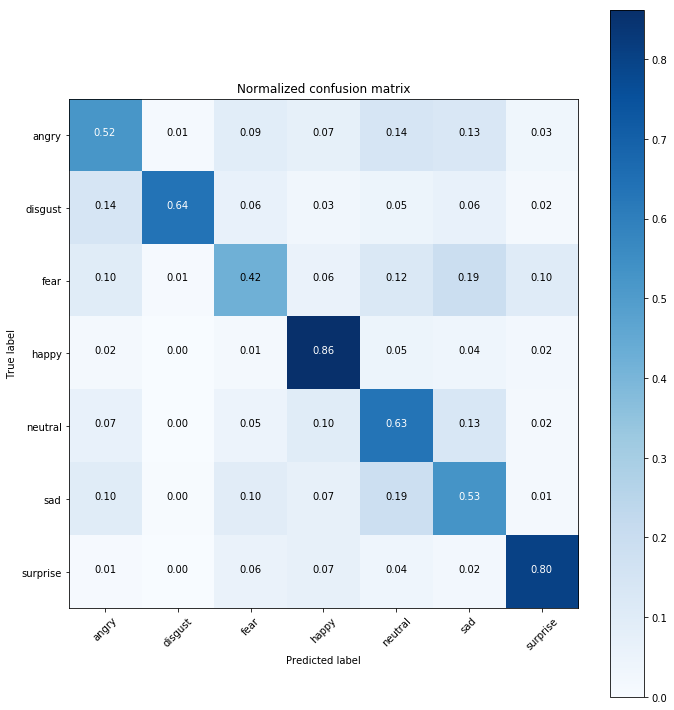

In [6]:
# show the confusion matrix of our predictions

# compute predictions
predictions = loaded_model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces because it confuses them with sad faces.

With more research and more resources this model could certainly be improved, but the goal of this study was primarily to focus on obtaining a fairly good model compared to what has been done in this field. 

Now it's time to try our model in a real situation! We will use flask to serve our model in order to perform real-time predictions with a webcam input.

797 surprise images
1018 fear images
960 angry images
1216 neutral images
1139 sad images
111 disgust images
1825 happy images
2
5
1
1
2
6
0
0
0
1
2
2
5
2
0
4
1
1
6
4
2


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

0
0
4
1
0
2
0
0
2
1
1
2
3
4
0
2
0
1
2
3
2
5
0
4
1
2
2
5
0
5
4
1
5
0
0
0
0
1
1
5
6
0
0
4


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

6
0
4
3
0
3
4
1
1
5
4
4
0
5
0
0
2
4
0
0
0
1
5
0
4
3
3
0
1
5
2
5
6
2
0
1
5
5
2
4
2
4
1
1
0
3
5
0


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

5
0
5
2
2
0
2
2
1
1
3
0
2
0
0
1
1
5
0
0
4
2
3
1
3
0
0
0
0
0
0
5
6
0
4
1
1
1
4
4
0
0
2
1
0
2
6
0
0
0


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

1
0
2
2
4
0
0
1
1
0
2
5
4
0
5
1
6
6
3
4
5
1
0
2
2
5
4
4
2
5
2
5
4
3
4
0
1
4
4
0
0
3
1
1
5
4
0
3
0
1


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

1
2
2
0
0
2
1
1
4
5
0
0
0
1
1
5
5
4
0
2
1
1
2
2
0
5
0
1
1
5
5
2
3
5
1
1
2
2
0
0
4
1
1
2
4
0


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

3
3
1
1
5
0
6
5
3
2
1
2
6
5
0
0
1
5
2
0
0
0
0
1
1
5
0
0
0
0
1
2
2
2
4
0
5
4
4
4
0
0
0
0
0


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

0
6
5
4
0
5
1
1
5
2
0
2
0
1
3
6
2
2
1
0
1
3
0
0
5
0
0
0
1
5
2
5
4
0
2
1
5
5
0
0
2
1
0
2
5
4
1
2


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

1
6
5
6
0
0
0
2
1
2
6
0
3
0
0
0
5
0
5
0
0
3
1
2
2
4
0
0
2
1
2
2
2
0
5
2
2
0
3
4
4
5
2
1
0
5
3
0
0
6
1


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

2
6
0
0
0
2
1
4
2
6


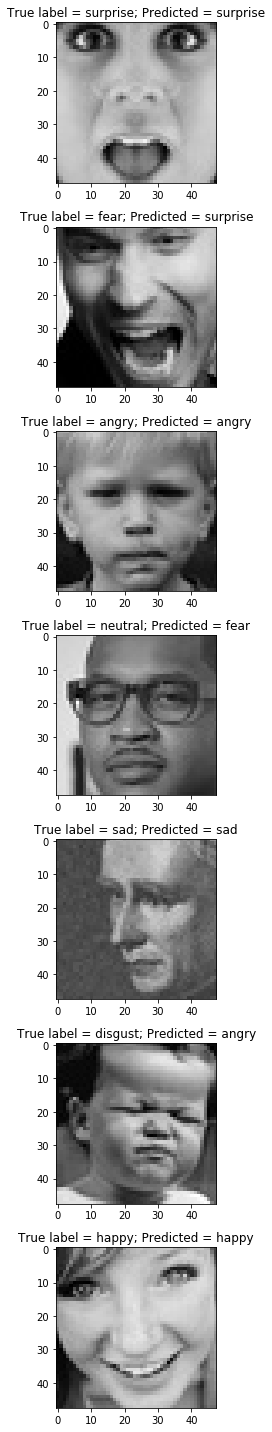

In [70]:
validation_len_list = []
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")
    validation_len_list.append(len(os.listdir(base_path + "validation/" + expression)))
    
cpt = 0
plt.figure(1, figsize=(12,20))

select = 0 #0, 13, 20

ver = 0
for i in range(111):
    
    select += 1
    cpt = 0
    
    for expression in os.listdir(base_path + "validation"):

        #print(os.listdir(base_path + "validation/" + expression)[0])

        if cpt > 0:
            print(np.argmax(predictions[select + validation_len_list[cpt-1]]))
            predict_int = np.argmax(predictions[select + validation_len_list[cpt-1]])
        else:
            print(np.argmax(predictions[select]))
            predict_int = np.argmax(predictions[select])

        predict = os.listdir(base_path + "validation")[predict_int]

        cpt = cpt + 1
        plt.subplot(7,1,cpt)
        img = load_img(base_path + "validation/" + expression + "/" +os.listdir(base_path + "validation/" + expression)[select], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")
        plt.title("True label = " + expression + "; Predicted = " + predict)
        
    if (predict == expression):
        ver += 1;
        
    if ver == 3:
        break;
 
plt.tight_layout()
plt.show()